# 01 - Exploration des Donnees EuroSAT

Ce notebook explore le dataset EuroSAT et les classes agricoles selectionnees.

**Objectifs :**
- Charger le dataset EuroSAT et filtrer les classes agricoles
- Visualiser des echantillons de chaque classe
- Analyser la distribution des classes
- Tester la simulation de secheresse
- Calculer et comparer les NDVI proxy

In [1]:
"""
Configuration Google Drive pour sauvegarde outputs.
Les notebooks restent sur GitHub, seuls les checkpoints/resultats vont dans Drive.
"""

from google.colab import drive
import os
import sys

# Montage Drive
drive.mount('/content/drive', force_remount=True)

# Chemin racine pour les outputs uniquement
DRIVE_OUTPUTS = "/content/drive/MyDrive/SatelliteGAN-Outputs"

# Creation structure outputs
for subdir in [
    'data/eurosat', 'data/processed_drought',
    'cyclegan/checkpoints', 'cyclegan/generated_images', 'cyclegan/losses',
    'diffusion/checkpoints', 'diffusion/samples', 'diffusion/losses',
    'evaluation/metrics', 'evaluation/comparisons', 'evaluation/figures',
]:
    os.makedirs(f"{DRIVE_OUTPUTS}/{subdir}", exist_ok=True)

print(f"Drive monte : {DRIVE_OUTPUTS}")
print(f"Structure outputs creee")

# Clone du repo GitHub (code source)
if not os.path.exists('/content/SatelliteGAN-Climate-Agriculture'):
    !git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
    !pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

%cd /content/SatelliteGAN-Climate-Agriculture
sys.path.insert(0, '/content/SatelliteGAN-Climate-Agriculture')

print("Code source charge depuis GitHub")
print("Outputs seront sauvegardes dans Drive")

Mounted at /content/drive
Drive monte : /content/drive/MyDrive/SatelliteGAN-Outputs
Structure outputs creee
Cloning into '/content/SatelliteGAN-Climate-Agriculture'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 17), reused 44 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 636.06 KiB | 9.22 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/SatelliteGAN-Climate-Agriculture
Code source charge depuis GitHub
Outputs seront sauvegardes dans Drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from src.config import DEVICE, AGRICULTURAL_CLASSES, IMAGE_SIZE
from src.dataset import get_agricultural_dataset, split_dataset, get_dataloader
from src.preprocessing import (
    get_train_transform, get_eval_transform,
    simulate_drought, denormalize, tensor_to_numpy, compute_ndvi_proxy
)

print(f"Device : {DEVICE}")
print(f"Classes agricoles : {AGRICULTURAL_CLASSES}")

Device : cuda
Classes agricoles : ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']


## 1. Chargement du dataset

In [3]:
# Charger le dataset avec les transformations d'evaluation (pas d'augmentation)
dataset = get_agricultural_dataset(transform=get_eval_transform())

print(f"\nNombre total d'images : {len(dataset)}")
print(f"Classes : {dataset.class_names}")
print(f"Taille d'une image : {dataset[0][0].shape}")

100%|██████████| 94.3M/94.3M [00:01<00:00, 70.4MB/s]


EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']

Nombre total d'images : 10500
Classes : ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']
Taille d'une image : torch.Size([3, 64, 64])


## 2. Distribution des classes

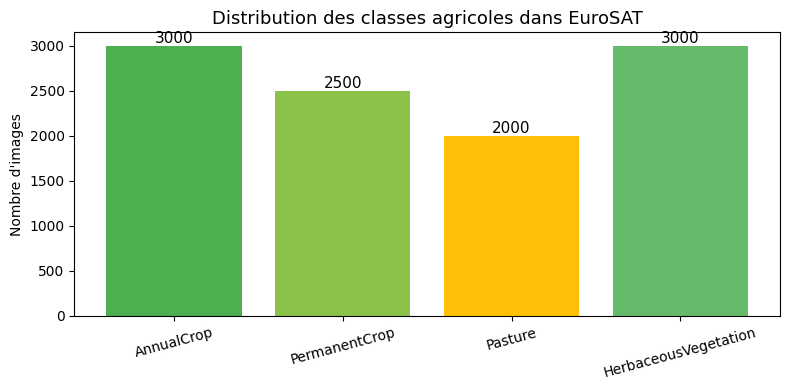


Resume :
  AnnualCrop                :  3000 images (28.6%)
  PermanentCrop             :  2500 images (23.8%)
  Pasture                   :  2000 images (19.0%)
  HerbaceousVegetation      :  3000 images (28.6%)


In [4]:
# Compter les images par classe
label_counts = Counter(dataset.labels)
class_names = dataset.class_names

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    [class_names[i] for i in sorted(label_counts.keys())],
    [label_counts[i] for i in sorted(label_counts.keys())],
    color=['#4CAF50', '#8BC34A', '#FFC107', '#66BB6A']
)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11)

ax.set_title('Distribution des classes agricoles dans EuroSAT', fontsize=13)
ax.set_ylabel('Nombre d\'images')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/class_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nResume :")
for idx in sorted(label_counts.keys()):
    pct = label_counts[idx] / len(dataset) * 100
    print(f"  {class_names[idx]:25s} : {label_counts[idx]:5d} images ({pct:.1f}%)")

## 3. Visualisation d'echantillons par classe

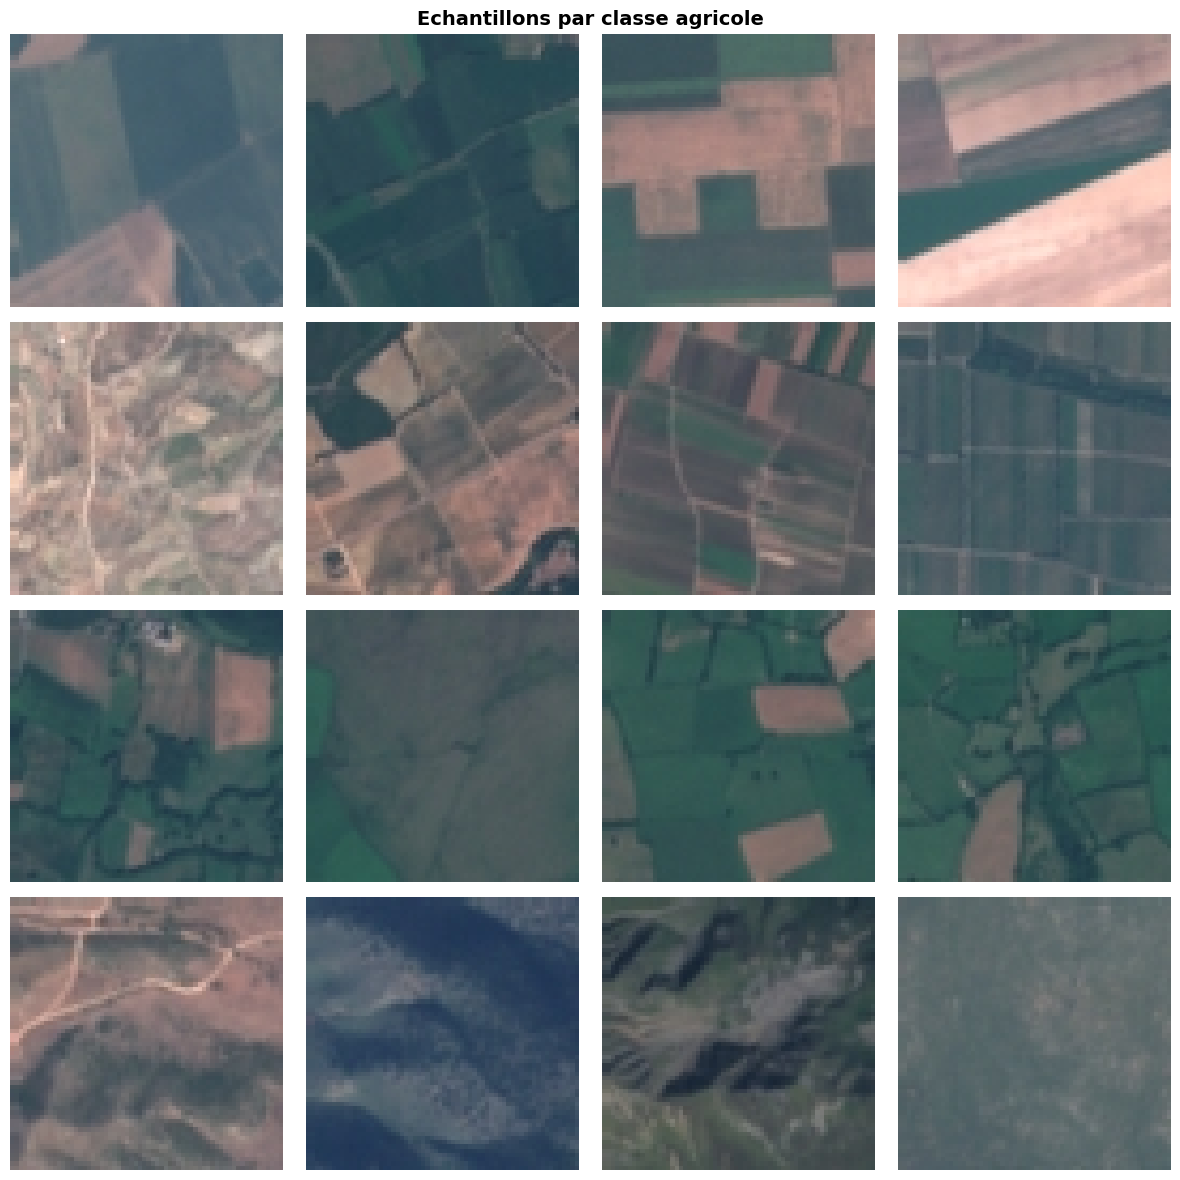

In [5]:
# Afficher 4 images aleatoires par classe
n_per_class = 4
fig, axes = plt.subplots(len(class_names), n_per_class, figsize=(12, 3 * len(class_names)))

for class_idx, class_name in enumerate(class_names):
    # Trouver les indices de cette classe
    indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
    # Echantillonner aleatoirement
    sample_indices = np.random.choice(indices, n_per_class, replace=False)

    for col, idx in enumerate(sample_indices):
        img, label = dataset[idx]
        img_np = tensor_to_numpy(img)
        axes[class_idx, col].imshow(img_np)
        axes[class_idx, col].axis('off')
        if col == 0:
            axes[class_idx, col].set_ylabel(class_name, fontsize=11, rotation=0,
                                             labelpad=80, va='center')

plt.suptitle('Echantillons par classe agricole', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/samples_per_class.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. Simulation de secheresse

On applique notre transformation spectrale pour simuler l'effet de la secheresse.
C'est une approximation grossiere -- le CycleGAN apprendra une transformation plus realiste.

EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']


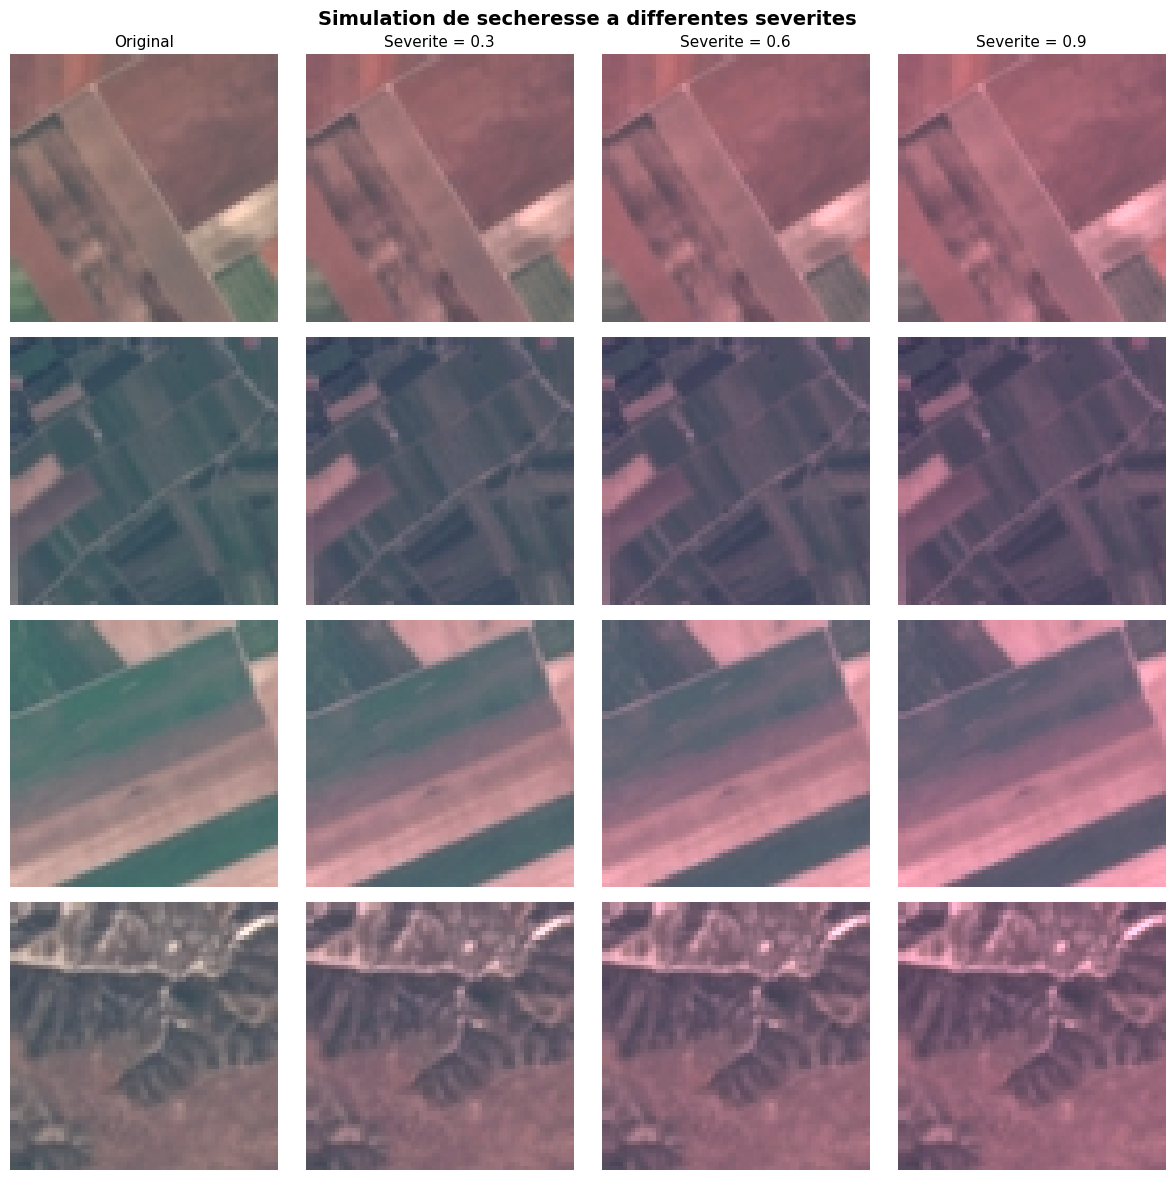

In [6]:
# Charger des images SANS normalisation pour la simulation de secheresse
from torchvision import transforms
from PIL import Image

# On prend quelques images brutes pour la demo
raw_dataset = get_agricultural_dataset(transform=transforms.Resize(IMAGE_SIZE))

# Afficher Normal vs Secheresse a differentes severites
n_samples = 4
severities = [0.3, 0.6, 0.9]
indices = np.random.choice(len(raw_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 1 + len(severities),
                          figsize=(3 * (1 + len(severities)), 3 * n_samples))

for row, idx in enumerate(indices):
    img, label = raw_dataset[idx]
    if isinstance(img, torch.Tensor):
        img_pil = transforms.ToPILImage()(img)
    else:
        img_pil = img

    # Image originale
    axes[row, 0].imshow(img_pil)
    axes[row, 0].axis('off')
    if row == 0:
        axes[row, 0].set_title('Original', fontsize=11)

    # Images avec secheresse
    for col, sev in enumerate(severities):
        drought_img = simulate_drought(img_pil, severity=sev)
        axes[row, col + 1].imshow(drought_img)
        axes[row, col + 1].axis('off')
        if row == 0:
            axes[row, col + 1].set_title(f'Severite = {sev}', fontsize=11)

plt.suptitle('Simulation de secheresse a differentes severites',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/drought_simulation.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Analyse NDVI proxy

Le NDVI (Normalized Difference Vegetation Index) est un indicateur de la sante de la vegetation.
On utilise un proxy base sur les bandes RGB car on n'a pas la bande NIR.

EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']


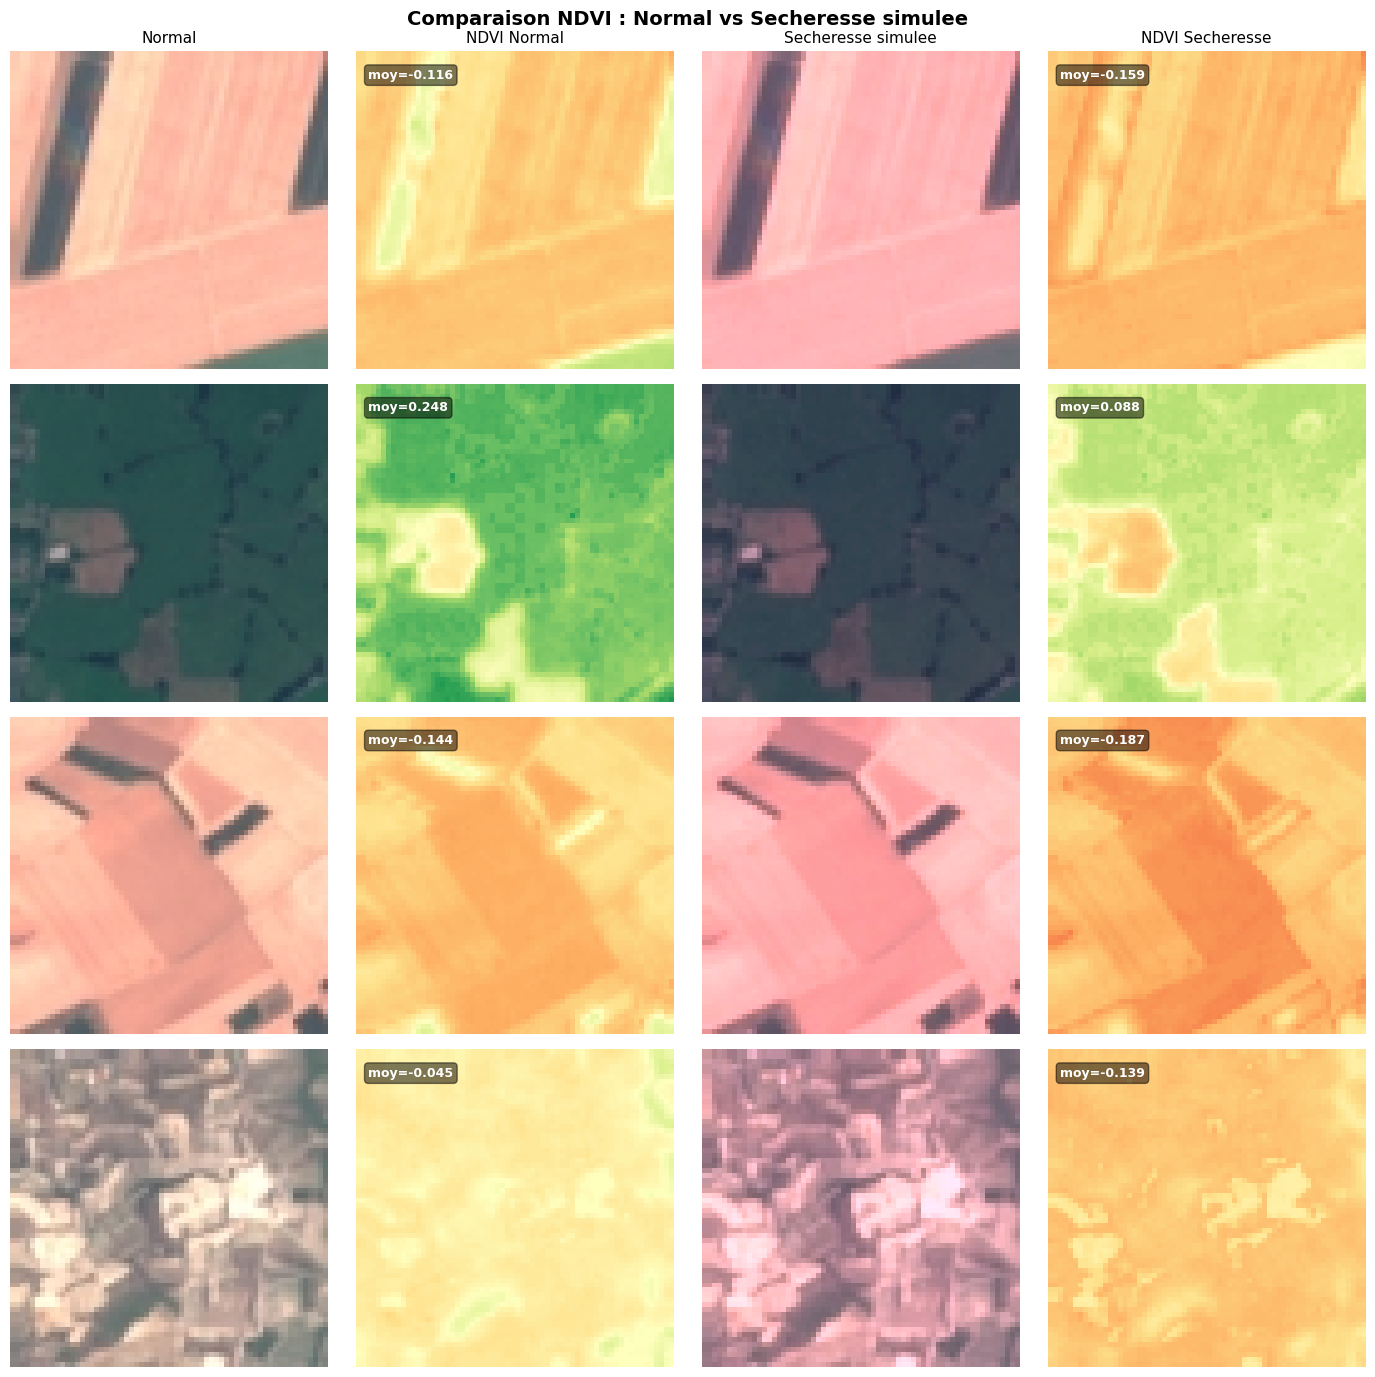

In [7]:
# Comparer NDVI entre images normales et secheresse
eval_dataset = get_agricultural_dataset(transform=get_eval_transform())
n_samples = 4
indices = np.random.choice(len(eval_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(14, 3.5 * n_samples))
col_titles = ['Normal', 'NDVI Normal', 'Secheresse simulee', 'NDVI Secheresse']

for row, idx in enumerate(indices):
    img_normal, _ = eval_dataset[idx]

    # Simuler la secheresse sur la version PIL
    raw_img, _ = raw_dataset[idx]
    if isinstance(raw_img, torch.Tensor):
        img_pil = transforms.ToPILImage()(raw_img)
    else:
        img_pil = raw_img
    drought_pil = simulate_drought(img_pil, severity=0.6)

    # Transformer la version secheresse en tensor normalise
    eval_transform = get_eval_transform()
    img_drought = eval_transform(drought_pil)

    # Calculer NDVI
    ndvi_normal = compute_ndvi_proxy(img_normal).numpy()
    ndvi_drought = compute_ndvi_proxy(img_drought).numpy()

    # Afficher
    axes[row, 0].imshow(tensor_to_numpy(img_normal))
    axes[row, 1].imshow(ndvi_normal, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
    axes[row, 2].imshow(tensor_to_numpy(img_drought))
    axes[row, 3].imshow(ndvi_drought, cmap='RdYlGn', vmin=-0.5, vmax=0.5)

    for col in range(4):
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(col_titles[col], fontsize=11)

    # Annoter les NDVI moyens
    axes[row, 1].text(2, 5, f'moy={ndvi_normal.mean():.3f}',
                       color='white', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    axes[row, 3].text(2, 5, f'moy={ndvi_drought.mean():.3f}',
                       color='white', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

plt.suptitle('Comparaison NDVI : Normal vs Secheresse simulee',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/ndvi_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Split train/val/test

In [8]:
# Verifier le split
train_set, val_set, test_set = split_dataset(eval_dataset)

print(f"\nTaille des ensembles :")
print(f"  Train : {len(train_set)} images")
print(f"  Val   : {len(val_set)} images")
print(f"  Test  : {len(test_set)} images")
print(f"  Total : {len(train_set) + len(val_set) + len(test_set)} images")

Split : train=8400, val=1050, test=1050

Taille des ensembles :
  Train : 8400 images
  Val   : 1050 images
  Test  : 1050 images
  Total : 10500 images


## 7. Resume

**Observations :**
- Le dataset EuroSAT contient ~10k images pour les 4 classes agricoles
- La simulation de secheresse modifie visuellement les images de maniere coherente
- Le NDVI proxy diminue bien avec la severite de la secheresse
- Le split 80/10/10 donne un ensemble d'entrainement suffisant

**Prochaine etape :** Entrainer le CycleGAN pour apprendre une transformation
normal -> secheresse plus realiste que notre simulation spectrale.

Toutes les figures sont sauvegardees dans `Drive/SatelliteGAN-Outputs/evaluation/figures/`.